## Problem Statement
#### We are tasked to find association between employee's experience, skills, and traits for better management of human resources.
#### We will do that by recognizing patterns based on the given dataset and formulate meaningful association rules

# Data Exploration

### In this step we will observe the dataset and try to find some insights which can help in our next step of preprocessing the data

### Importing libraries

In [93]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx 

from apyori import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori #fpmax, fpgrowth

warnings.filterwarnings('ignore')

%matplotlib inline

### Reading input file

In [94]:
# Reading csv data file in the form of dataframe and printing it
path_to_input_file = os.path.join(os.getcwd(), 'Employee_skills_traits.csv')
employee_skills_df = pd.read_csv(path_to_input_file)
employee_skills_df

,ID,Employment period,Time in current department,Gender,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
0,6723,5,4,0,1,48,1,1,1,0,1,1,0,1
1,8923,5,3,1,1,26,1,1,0,0,1,1,0,0
2,2322,11,8,0,0,34,0,0,1,1,0,1,0,1
3,235,7,5,1,1,27,1,0,1,0,1,1,1,0
4,9523,18,8,0,0,38,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,6098,12,3,1,1,32,1,0,0,0,1,1,0,1
994,12133,16,8,1,0,36,1,1,1,0,0,0,1,1
995,854,11,4,0,1,34,1,0,1,0,1,1,0,0
996,13444,8,8,1,0,36,0,0,1,0,0,0,1,1


In [95]:
employee_skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 14 columns):
ID                                       998 non-null int64
Employment period                        998 non-null int64
Time in current department               998 non-null int64
Gender                                   998 non-null int64
Team leader                              998 non-null int64
Age                                      998 non-null int64
Member of professional organizations     998 non-null int64
.Net                                     998 non-null int64
SQL Server                               998 non-null int64
HTML CSS Java Script                     998 non-null int64
PHP mySQL                                998 non-null int64
Fast working                             998 non-null int64
Awards                                   998 non-null int64
Communicative                            998 non-null int64
dtypes: int64(14)
memory usage: 109.3 KB


- Data only has Integer values
- No variable column has null/missing values

### Removing whitespaces from column names

We observed that there is whitespace in the column names of the dataframe, hence we remove them.

In [96]:
employee_skills_df.columns = employee_skills_df.columns.str.strip()
employee_skills_df.head()

,ID,Employment period,Time in current department,Gender,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
0,6723,5,4,0,1,48,1,1,1,0,1,1,0,1
1,8923,5,3,1,1,26,1,1,0,0,1,1,0,0
2,2322,11,8,0,0,34,0,0,1,1,0,1,0,1
3,235,7,5,1,1,27,1,0,1,0,1,1,1,0
4,9523,18,8,0,0,38,0,0,0,1,1,1,1,1


In [97]:
employee_skills_df['Employment period'].unique()

array([ 5, 11,  7, 18, 10, 16, 19, 17, 20,  8,  1,  4, 13, 14,  6,  3, 15,
       12,  2,  9], dtype=int64)

- We observe that employment period in the dataset ranges from 1 to 20 years

In [98]:
employee_skills_df['Time in current department'].unique()

array([ 4,  3,  8,  5,  9,  7,  2, 11,  1, 10,  6, 12], dtype=int64)

- We observe that time in current department for employees in the dataset ranges from 1 to 12 years

In [99]:
employee_skills_df['Age'].unique()

array([48, 26, 34, 27, 38, 45, 36, 32, 39, 55, 37, 40, 44, 54, 43, 52, 42,
       33, 50, 35, 47, 53, 31, 49, 30, 28, 46, 51, 29, 41, 25, 24],
      dtype=int64)

- We observe that age of employees in the given dataset ranges from 24 to 55 years

### Understanding correlation between data points

In [100]:
correlation = employee_skills_df.corr()
correlation

,ID,Employment period,Time in current department,Gender,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
ID,1.000000,0.021231,0.045212,-0.002563,0.019724,0.058252,-0.003988,0.033203,0.027852,0.009756,0.001788,0.007470,-0.009040,0.006633
Employment period,0.021231,1.000000,0.495719,0.033907,-0.048001,0.164389,-0.042311,-0.086372,-0.041851,0.050546,0.029320,0.031121,0.016359,-0.080846
Time in current department,0.045212,0.495719,1.000000,0.009666,-0.005733,0.076987,-0.065801,-0.051051,-0.048757,0.005154,0.025756,0.049245,-0.006786,-0.017179
Gender,-0.002563,0.033907,0.009666,1.000000,0.024301,0.010982,-0.008624,-0.027479,-0.045607,0.000482,0.062893,-0.053953,0.024180,-0.024820
Team leader,0.019724,-0.048001,-0.005733,0.024301,1.000000,-0.010266,-0.037924,0.024444,0.002392,-0.034202,0.002360,0.015985,-0.002036,0.107978
Age,0.058252,0.164389,0.076987,0.010982,-0.010266,1.000000,-0.052271,-0.002076,0.001022,-0.008468,0.012754,0.030642,0.022791,-0.007664
Member of professional organizations,-0.003988,-0.042311,-0.065801,-0.008624,-0.037924,-0.052271,1.000000,-0.004938,0.009069,-0.017721,-0.071107,-0.019924,0.010102,0.008869
.Net,0.033203,-0.086372,-0.051051,-0.027479,0.024444,-0.002076,-0.004938,1.000000,0.037948,0.008765,0.001980,-0.001729,-0.019877,-0.052270
SQL Server,0.027852,-0.041851,-0.048757,-0.045607,0.002392,0.001022,0.009069,0.037948,1.000000,0.026858,-0.052332,0.000289,0.034301,-0.070264
HTML CSS Java Script,0.009756,0.050546,0.005154,0.000482,-0.034202,-0.008468,-0.017721,0.008765,0.026858,1.000000,0.002714,-0.000096,0.005949,0.015373


# Data Preprocessing

### In this step we take the learning from our data exploration step and prepare data in order to get meaningful associations while applying the algorithm

### Dropping duplicate records, if any

In [101]:
employee_skills_df.shape
duplicate_records = employee_skills_df[employee_skills_df.duplicated(keep=False)]
if not duplicate_records.empty:
    employee_skills_df.drop_duplicates(keep=False, inplace=True)
employee_skills_df.shape

(998, 14)

### Removing columns which are not relevant to finding associations
#### Studying the correlation table we see that ID and Gender are having negative or negligent correlations with most of the other attributes and can be considered irrelevant to finding out associations, it will be wise to drop them before applying the algorithm

In [102]:
employee_skills_df.drop(columns=['ID', 'Gender'], inplace=True)
employee_skills_df

,Employment period,Time in current department,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
0,5,4,1,48,1,1,1,0,1,1,0,1
1,5,3,1,26,1,1,0,0,1,1,0,0
2,11,8,0,34,0,0,1,1,0,1,0,1
3,7,5,1,27,1,0,1,0,1,1,1,0
4,18,8,0,38,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
993,12,3,1,32,1,0,0,0,1,1,0,1
994,16,8,0,36,1,1,1,0,0,0,1,1
995,11,4,1,34,1,0,1,0,1,1,0,0
996,8,8,0,36,0,0,1,0,0,0,1,1


# Data Conversion/Normalization


### In this step, we will first bin numeric attributes such as Employment Period, Age and Time using equal width binning and then convert them into categorical attributes

### Binning non categorical attributes

In [103]:
# Normalizing employment period values through equal width binning

employee_skills_df['Employment period'].describe()

employment_period_bin_label = ['0-5', '6-10', '11-15', '16-20']
cut_bins_employment_period = [0, 5, 10, 15, 20]
employee_skills_df['Employment period'] = pd.cut(employee_skills_df['Employment period'], bins=cut_bins_employment_period, labels=employment_period_bin_label)
employee_skills_df.head()


,Employment period,Time in current department,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
0,0-5,4,1,48,1,1,1,0,1,1,0,1
1,0-5,3,1,26,1,1,0,0,1,1,0,0
2,11-15,8,0,34,0,0,1,1,0,1,0,1
3,6-10,5,1,27,1,0,1,0,1,1,1,0
4,16-20,8,0,38,0,0,0,1,1,1,1,1


In [104]:
# Normalizing age values through equal width binning

employee_skills_df['Age'].describe()

age_bin_label = ['20-30', '31-40', '41-50', '51-60']
cut_bins_age = [20, 30, 40, 50, 60]
employee_skills_df['Age'] = pd.cut(employee_skills_df['Age'], bins=cut_bins_age, labels=age_bin_label)
employee_skills_df.head()


,Employment period,Time in current department,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
0,0-5,4,1,41-50,1,1,1,0,1,1,0,1
1,0-5,3,1,20-30,1,1,0,0,1,1,0,0
2,11-15,8,0,31-40,0,0,1,1,0,1,0,1
3,6-10,5,1,20-30,1,0,1,0,1,1,1,0
4,16-20,8,0,31-40,0,0,0,1,1,1,1,1


In [105]:
# Normalizing employee's time in current department values through equal width binning

employee_skills_df['Time in current department'].describe()

current_department_bin_label = ['0-3', '4-6', '7-9', '10-12']
cut_bins_curr_dept = [0, 3, 6, 9, 12]
employee_skills_df['Time in current department'] = pd.cut(employee_skills_df['Time in current department'], bins=cut_bins_curr_dept, labels=current_department_bin_label)
employee_skills_df.head()


,Employment period,Time in current department,Team leader,Age,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative
0,0-5,4-6,1,41-50,1,1,1,0,1,1,0,1
1,0-5,0-3,1,20-30,1,1,0,0,1,1,0,0
2,11-15,7-9,0,31-40,0,0,1,1,0,1,0,1
3,6-10,4-6,1,20-30,1,0,1,0,1,1,1,0
4,16-20,7-9,0,31-40,0,0,0,1,1,1,1,1


### Converting non categorical attributes into categorical attributes

In [106]:
employee_skills_df = pd.get_dummies(employee_skills_df, columns=['Employment period', 'Age', 'Time in current department'])
employee_skills_df.head()

,Team leader,Member of professional organizations,.Net,SQL Server,HTML CSS Java Script,PHP mySQL,Fast working,Awards,Communicative,Employment period_0-5,...,Employment period_11-15,Employment period_16-20,Age_20-30,Age_31-40,Age_41-50,Age_51-60,Time in current department_0-3,Time in current department_4-6,Time in current department_7-9,Time in current department_10-12
0,1,1,1,1,0,1,1,0,1,1,...,0,0,0,0,1,0,0,1,0,0
1,1,1,1,0,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,1,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,1,0
3,1,1,0,1,0,1,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,1,1,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0


# Data Mining

#### To check association among employee experience, skills and traits, we will perform association rule mining. 
The rules which we will be formulating has two elements :

- Antecedent : This is an item/group of items that are typically found in the Itemsets or Datasets.
- Consequent : This comes along as an item with an Antecedent/group of Antecedents.

#### Metrics of association :

> 1) **Support**: It gives the fraction of transactions which contains item A and B. Basically Support tells us about the frequently bought items or the combination of items bought frequently.
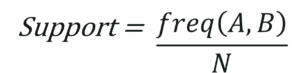

> Using support, we can filter out items that have low frequency

> 2) **Confidence** : It tells us how often the items A and B occur together, given the number times A occurs.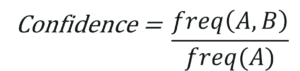

> Even after filtering with support and confidence, we can still have many items left. Creating association rules for them is a practically impossible task for anyone. This is where the concept of lift comes into play.

> 3) **Lift** : Lift indicates the strength of a rule over the random occurrence of A and B. It basically tells us the strength of any rule.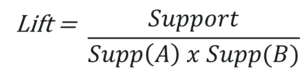



### Apriori Algorithm

Apiori algorithm is the most widely used algorithm to mine association rules. It is based on the concept that a subset of a frequent itemset must also be a frequent itemset. Frequent Itemset is an itemset whose support value is greater than a given threshold value.


The first step in implementing Apiori algorithm is to find frequent itemsets from the data. We start with support value of 0.4 and stop when we have enough frequent itemsets to extract rules.

In [107]:
support_list = [0.4, 0.3, 0.2, 0.1, 0.05]

for support in support_list:
    frequent_itemsets = apriori(employee_skills_df, min_support=support, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    print(f"For minimum support = {support}, number of frequent itemsets = {frequent_itemsets.shape[0]}")
    print(frequent_itemsets)
    print("-----------------------------------------------------------------------------")
    print()


For minimum support = 0.4, number of frequent itemsets = 10
    support                                itemsets  length
0  0.504008                           (Team leader)       1
1  0.489980  (Member of professional organizations)       1
2  0.476954                                  (.Net)       1
3  0.475952                            (SQL Server)       1
4  0.508016                  (HTML CSS Java Script)       1
5  0.477956                             (PHP mySQL)       1
6  0.503006                          (Fast working)       1
7  0.502004                                (Awards)       1
8  0.521042                         (Communicative)       1
9  0.423848                             (Age_31-40)       1
-----------------------------------------------------------------------------

For minimum support = 0.3, number of frequent itemsets = 12
     support                                itemsets  length
0   0.504008                           (Team leader)       1
1   0.489980  (Memb

### Based on the observations above, we choose the frequent itemsets by keeping the min support as 0.05 as we get enough itemsets to extract meaningful rules.

In [108]:
# Finding frequent itemsets with minimum support of 0.05
frequent_itemsets = apriori(employee_skills_df, min_support=0.05, use_colnames=True)

# Generating association rules using 
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
print(f"Rules generated with minimum support of 0.05 are {rules.shape[0]}")
rules.head()

Rules generated with minimum support of 0.05 are 5442


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Member of professional organizations),(Team leader),0.489980,0.504008,0.237475,0.484663,0.961617,-0.009479,0.962461
1,(Team leader),(Member of professional organizations),0.504008,0.489980,0.237475,0.471173,0.961617,-0.009479,0.964436
2,(Team leader),(.Net),0.504008,0.476954,0.246493,0.489066,1.025394,0.006104,1.023705
3,(.Net),(Team leader),0.476954,0.504008,0.246493,0.516807,1.025394,0.006104,1.026488
4,(SQL Server),(Team leader),0.475952,0.504008,0.240481,0.505263,1.002490,0.000597,1.002537


### Filtering rules with lift  and confidence

#### We can see that rules generated with minimum support value of 0.05 are 5442. Analysing these number of rules is an impossible task hence we need to refine our rule set using other metrics viz. confidence and lift. First we will take confidence of 65% and lift greater than equal to 1.

In [109]:
# Refining rules with confidence > 65% and lift >=1
conf_vl = 0.65
lift_vl = 1
rules = rules[(rules['confidence']>=conf_vl) & (rules['lift']>=lift_vl)]
print(f"Rules left by refining with min confidence = {conf_vl} and lift = {lift_vl} are {rules.shape[0]}")
rules

Rules left by refining with min confidence = 0.65 and lift = 1 are 26


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
295,(Employment period_0-5),(Time in current department_0-3),0.260521,0.322645,0.176353,0.676923,2.098041,0.092297,2.096574
878,"(Team leader, Employment period_0-5)",(Communicative),0.145291,0.521042,0.097194,0.668966,1.283899,0.021492,1.446852
940,"(Team leader, Employment period_0-5)",(Time in current department_0-3),0.145291,0.322645,0.100200,0.689655,2.137503,0.053323,2.182587
1454,"(Member of professional organizations, Employm...",(Time in current department_0-3),0.133267,0.322645,0.092184,0.691729,2.143931,0.049187,2.197273
1876,"(Employment period_0-5, .Net)",(Time in current department_0-3),0.133267,0.322645,0.092184,0.691729,2.143931,0.049187,2.197273
2218,"(SQL Server, Employment period_0-5)",(Time in current department_0-3),0.133267,0.322645,0.090180,0.676692,2.097324,0.047183,2.095074
2500,"(HTML CSS Java Script, Employment period_0-5)",(Time in current department_0-3),0.121242,0.322645,0.083166,0.685950,2.126020,0.044048,2.156840
2716,"(Employment period_0-5, PHP mySQL)",(Time in current department_0-3),0.125251,0.322645,0.089178,0.712000,2.206758,0.048767,2.351926
2956,"(Awards, Employment period_0-5)",(Time in current department_0-3),0.131263,0.322645,0.087174,0.664122,2.058366,0.044823,2.016670
3003,"(Time in current department_4-6, Employment pe...",(Communicative),0.084168,0.521042,0.057114,0.678571,1.302335,0.013259,1.490091


### We will further refine our rule set by taking confidence >= 70% and lift >=1

In [110]:
# Refining rules with confidence > 70% and lift >=1
conf_vl = 0.70
lift_vl = 1
rules = rules[(rules['confidence']>=conf_vl) & (rules['lift']>=lift_vl)]

# Sorting rules in descending order by confidence
rules.sort_values(by='confidence',ascending=False,inplace=True)
print(f"Rules left by refining with min confidence = {conf_vl} and lift = {lift_vl} are {rules.shape[0]}")
rules

Rules left by refining with min confidence = 0.7 and lift = 1 are 7


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4098,"(Awards, Team leader, Employment period_0-5)",(Communicative),0.074148,0.521042,0.058116,0.783784,1.504262,0.019482,2.215180
4381,"(Member of professional organizations, Employm...",(Time in current department_0-3),0.066132,0.322645,0.050100,0.757576,2.348014,0.028763,2.794088
4127,"(Awards, Team leader, Time in current departme...",(Communicative),0.086172,0.521042,0.062124,0.720930,1.383631,0.017225,1.716266
4099,"(Awards, Communicative, Employment period_0-5)",(Team leader),0.081162,0.504008,0.058116,0.716049,1.420710,0.017210,1.746754
2716,"(Employment period_0-5, PHP mySQL)",(Time in current department_0-3),0.125251,0.322645,0.089178,0.712000,2.206758,0.048767,2.351926
3356,"(Member of professional organizations, Team le...",(Communicative),0.074148,0.521042,0.052104,0.702703,1.348649,0.013470,1.611040
3398,"(Member of professional organizations, Team le...",(Time in current department_0-3),0.074148,0.322645,0.052104,0.702703,2.177942,0.028181,2.278375


# Data Visualization

#### Printing rules in the format of {antecedents} ---> {consequents}

By refining our rule set on basis of confidence and lift, we have got 7 rules. We will not print these rules in understandable format.

In [111]:
# Printing generated rules
for idx in rules.index:
    print(f"{list(rules['antecedents'][idx])} ====> {list(rules['consequents'][idx])}")

['Awards', 'Team leader', 'Employment period_0-5'] ====> ['Communicative']
['Member of professional organizations', 'Employment period_0-5', '.Net'] ====> ['Time in current department_0-3']
['Awards', 'Team leader', 'Time in current department_0-3'] ====> ['Communicative']
['Awards', 'Communicative', 'Employment period_0-5'] ====> ['Team leader']
['Employment period_0-5', 'PHP mySQL'] ====> ['Time in current department_0-3']
['Member of professional organizations', 'Team leader', 'Employment period_0-5'] ====> ['Communicative']
['Member of professional organizations', 'Team leader', 'Employment period_0-5'] ====> ['Time in current department_0-3']


### Scatter plot to look at support and confidence values of selected rules

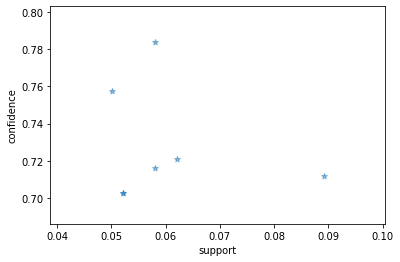

In [112]:
support = rules["support"]
confidence = rules["confidence"]
plt.scatter(support, confidence, alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

### Using directed graph to look at associations between the rules. 

- Yellow dots represent the rules
- Green dots shows antecedents and consequents
- Incoming arrows into a rule shows the antecendents
- Outgoing arrows from a rule shows the consequents

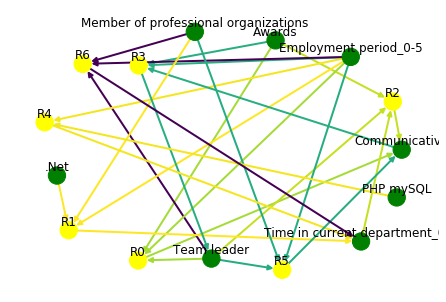

In [113]:
rules_to_show = 7

G1 = nx.DiGraph()

color_map=[]
N = 50
colors = np.random.rand(N)    
strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6']   


for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])

    for a in rules.iloc[i]['antecedents']:
        G1.add_nodes_from([a])
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

    for c in rules.iloc[i]['consequents']:
        G1.add_nodes_from([c])
        G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

for node in G1:
   found_a_string = False
   for item in strs: 
       if node==item:
            found_a_string = True
   if found_a_string:
        color_map.append('yellow')
   else:
        color_map.append('green')       


edges = G1.edges()
colors = [G1[u][v]['color'] for u,v in edges]
weights = [G1[u][v]['weight'] for u,v in edges]

pos = nx.spring_layout(G1, k=30, scale=1)
nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            

for p in pos:  # raise text positions
    pos[p][1] += 0.07
nx.draw_networkx_labels(G1, pos)
plt.show()

# Importance of Discovered Rules

#### As an outcome of our knowledge discovery process, we found the following rules with minimum support - 5%, confidence - 70% and lift > 1

| Antecedent(s) | Consequent
| :- | :-|
| Team leader, Awards, Employment period(0-5) | Communicative
| Member of professional organizations, .Net, Employment period(0-5) | Time in current department(0-3)
| Team leader, Awards, Time in current department(0-3) | Communicative
| Awards, Employment period(0-5), Communicative | Team leader
| Employment period(0-5), PHP mySQL | Time in current department(0-3)
| Member of professional organizations, Team leader, Employment period(0-5) | Communicative
| Member of professional organizations, Team leader, Employment period(0-5) | Time in current department(0-3)

#### Based on the associations we can make the following suggestions to improve/manage human resources


- An employee is likely to be Communicative, if he is a Team leader and have an experience between 0 to 5 years or  has been a member of professional organization


- An employee is likely to be a Team leader if has experience between 0 to 5 years, is Communicative and has won an award


- An employee is likely to spend more time working in same department if he/she is either skilled in PHP MySQL or .Net, is a member of professional organization and has experience ranging from 0 to 5 years


- No direct association was found between an employee possessing more number of skills and being a Team leader


- No direct association was found between an employee possessing more number of skills and being Communicative


- Age of an employee does not seem to be a factor in an employee being more Communicative or a Team leader


- If an employee is a member of professional organization he/she s likely to stay longer working one department and are Communicative


